In [1]:
%load_ext autoreload
%autoreload 2
import math
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from utils.data_manager import *
from utils.metrics import *
from utils.models import *
from utils.preprocessing import *
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.preprocessing import PolynomialFeatures


In [2]:
df_raw = get_train(dropNull=True)
df_train_raw, df_test_raw = split_by_date(df_raw, split_ratio=0.2)
df_raw.head()

data/optiver-trading-at-the-close/train.csv - loaded


,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id
row_id,,,,,,,,,,,,,,,,
0_0_0,0,0,0,3180602.69,1,0.999812,13380276.64,NaN,NaN,0.999812,60651.50,1.000026,8493.03,1.0,-3.029704,0
0_0_1,1,0,0,166603.91,-1,0.999896,1642214.25,NaN,NaN,0.999896,3233.04,1.000660,20605.09,1.0,-5.519986,0
0_0_2,2,0,0,302879.87,-1,0.999561,1819368.03,NaN,NaN,0.999403,37956.00,1.000298,18995.00,1.0,-8.389950,0
0_0_3,3,0,0,11917682.27,-1,1.000171,18389745.62,NaN,NaN,0.999999,2324.90,1.000214,479032.40,1.0,-4.010200,0
0_0_4,4,0,0,447549.96,-1,0.999532,17860614.95,NaN,NaN,0.999394,16485.54,1.000016,434.10,1.0,-7.349849,0


In [3]:
print('all')
print(df_raw.target.mean())
print(df_raw[df_raw['imbalance_buy_sell_flag']==-1].target.mean())
print(df_raw[df_raw['imbalance_buy_sell_flag']==0].target.mean())
print(df_raw[df_raw['imbalance_buy_sell_flag']==1].target.mean())

print('train')
print(df_train_raw.target.mean())
print(df_train_raw[df_train_raw['imbalance_buy_sell_flag']==-1].target.mean())
print(df_train_raw[df_train_raw['imbalance_buy_sell_flag']==0].target.mean())
print(df_train_raw[df_train_raw['imbalance_buy_sell_flag']==1].target.mean())

models_base = {
    'model null' :(Model_base(), Preprocessing_null()),
    'model baseline':(Imbalanced(), Preprocessing_null()),
    'model cst all.mean':(BaseImbalanced(-0.0475888608336268, 0), Preprocessing_null()),
    'model cst train.mean':(BaseImbalanced(-0.04728118963733477, 0), Preprocessing_null()),
    'model base all.mean':(BaseImbalanced(-0.0475888608336268, 0.1), Preprocessing_null()),
    'model base train.mean':(BaseImbalanced(-0.04728118963733477, 0.1), Preprocessing_null()),
    'model imbalance adj all':(BaseImbalanced_values(-0.20227519213446324, -0.0628055349951964, 0.12037589113790591), Preprocessing_null()),
    'model imbalance adj train':(BaseImbalanced_values(-0.22745859858456322, -0.06500647314559627, 0.142972352764706), Preprocessing_null()),
}

imbal = [x *0.01 for x in range(1,101)]

model_imbal_all = {
    f'model base all_{x}':(BaseImbalanced(-0.0475888608336268, x), Preprocessing_null())
    for x in imbal
}

model_imbal_train= {
    f'model base train_{x}':(BaseImbalanced(-0.04728118963733477, x), Preprocessing_null())
    for x in imbal
}

models_base= {**models_base, **model_imbal_all, **model_imbal_train}

all
-0.0475888608336268
-0.20227519213446324
-0.0628055349951964
0.12037589113790591
train
-0.04728118963733477
-0.22745859858456322
-0.06500647314559627
0.142972352764706


In [4]:
cols = [
    'stock_id',
    'seconds_in_bucket',
    'reference_price',
    'matched_size',
    'bid_price',
    'bid_size',
    'ask_price',
    'ask_size',
    'wap',
    'imbalance_size_rel',
]

cols = [
    # 'stock_id',
    # 'seconds_in_bucket',
    # 'reference_price',
    # 'matched_size',
    # 'bid_price',
    # 'bid_size',
    # 'ask_price',
    # 'ask_size',
    # 'wap',
    'imb/volume',
]
models_Lin = {
    'model linReg +':(
        Sklearn(LinearRegression()), 
        ChainPrepro((Preprocessing_base(),RestrictCols(cols)))
        ),
    'model linReg + poly':(
        Sklearn(LinearRegression()), 
        ChainPrepro((Preprocessing_base(),RestrictCols(cols),PolynomialFeatures(2)))
        ),
}

In [5]:
alphas = [round(10**(alpha/3)*0.001,4) for alpha in range(0,8)]

model_lasso = {f'Lasso_{a}': (
    Sklearn(Lasso(a)),
    ChainPrepro((Preprocessing_base(),RestrictCols(cols)))
    ) for a in alphas}

model_lasso_poly = {f'Lasso_{a} poly': (
    Sklearn(Lasso(a)),
    ChainPrepro((Preprocessing_base(),RestrictCols(cols),PolynomialFeatures(2)))
    ) for a in alphas}

model_ridge = {f'Ridge_{a}': (
    Sklearn(Ridge(a)),
    ChainPrepro((Preprocessing_base(),RestrictCols(cols)))
    ) for a in alphas
    }

model_ridge_poly = {
    f'Ridge_{a} poly': (
        Sklearn(Ridge(a)),
        ChainPrepro((Preprocessing_base(),RestrictCols(cols),PolynomialFeatures(2)))
    ) for a in alphas
        }

In [6]:
from xgboost import XGBRegressor

xgb = XGBRegressor(
        objective='reg:squarederror',
        max_depth=8,
        subsample=0.6,
        colsample_bytree=0.5,
        learning_rate=0.01,
        reg_lambda=1,
        reg_alpha=0.5,
        n_estimators=3500,
        random_state=42,
        verbosity=0
    )

models_xgb = {
    'model xgb +':(
        Sklearn(xgb), 
        ChainPrepro((Preprocessing_base(),RestrictCols(cols)))),
    'model xgb + poly':(
        Sklearn(xgb), 
        ChainPrepro((Preprocessing_base(),RestrictCols(cols),PolynomialFeatures(2)))),
}

In [7]:
# models_dict = {**models_base, **models_Lin, **model_lasso, **model_lasso_poly, **model_ridge, **model_ridge_poly, **models_xgb}
models_dict = {**models_base, **models_Lin}


score=[]
data_res=[]
for name, pipe in tqdm(models_dict.items()):
    
    model, preprocess = pipe
    df_res_train, df_res_test, mae_train, mae_test = train_test_score_fast(df_train_raw, df_test_raw, model=model, preprocess=preprocess)
    score.append((name, mae_train, mae_test))
    data_res.append((name, df_res_train, df_res_test))
    print(name, mae_train, mae_test)

  1%|          | 2/210 [00:01<02:05,  1.65it/s]

model null 6.495554404736472 6.060085367628662
model baseline 6.494699965252276 6.059927118550247


  2%|▏         | 4/210 [00:01<01:08,  3.02it/s]

model cst all.mean 6.49529600604432 6.059967248807287
model cst train.mean 6.4952968702284934 6.0599671421601355


  3%|▎         | 6/210 [00:02<00:50,  4.04it/s]

model base all.mean 6.494443674883186 6.059855531178103
model base train.mean 6.49444453038579 6.059855129648676


  4%|▍         | 8/210 [00:02<00:44,  4.58it/s]

model imbalance adj all 6.494409889910547 6.0603489802826696
model imbalance adj train 6.494487198852728 6.060654093318228


  5%|▍         | 10/210 [00:02<00:41,  4.79it/s]

model base all_0.01 6.495167486454798 6.059905446878092
model base all_0.02 6.495048474128255 6.05985516545771


  5%|▌         | 11/210 [00:03<00:41,  4.79it/s]

model base all_0.03 6.494939457750115 6.05981703844875


  6%|▌         | 12/210 [00:03<00:41,  4.77it/s]

model base all_0.04 6.494840121333989 6.059789312776935


  6%|▌         | 13/210 [00:03<00:43,  4.49it/s]

model base all_0.05 6.4947503700316895 6.0597722534558285


  7%|▋         | 14/210 [00:03<00:49,  3.96it/s]

model base all_0.06 6.494670304872012 6.0597671164907085


  7%|▋         | 15/210 [00:04<00:47,  4.13it/s]

model base all_0.07 6.4945991128960925 6.059772410260141


  8%|▊         | 16/210 [00:04<00:45,  4.30it/s]

model base all_0.08 6.494537952092241 6.059789132969886


  8%|▊         | 17/210 [00:04<00:43,  4.42it/s]

model base all_0.09 6.494485969571879 6.059816660342005


  9%|▊         | 18/210 [00:04<00:42,  4.49it/s]

model base all_0.1 6.494443674883186 6.059855531178103


  9%|▉         | 19/210 [00:04<00:41,  4.57it/s]

model base all_0.11 6.4944115263693964 6.059905155901942
model base all_0.12 6.494389127423847 6.059966272775018


 10%|█         | 21/210 [00:05<00:40,  4.70it/s]

model base all_0.13 6.4943764908818915 6.060038629482336


 10%|█         | 22/210 [00:05<00:40,  4.69it/s]

model base all_0.14 6.494373622404889 6.060122805113049


 11%|█         | 23/210 [00:05<00:40,  4.62it/s]

model base all_0.15 6.49437992787989 6.060217870932993


 11%|█▏        | 24/210 [00:06<00:39,  4.67it/s]

model base all_0.16 6.494396084274947 6.060323957891806


 12%|█▏        | 25/210 [00:06<00:39,  4.63it/s]

model base all_0.17 6.494421713680682 6.060441011767221


 12%|█▏        | 26/210 [00:06<00:39,  4.64it/s]

model base all_0.18 6.4944566824131655 6.060569237030579


 13%|█▎        | 27/210 [00:06<00:39,  4.65it/s]

model base all_0.19 6.494501441775369 6.06070851884029


 13%|█▎        | 28/210 [00:06<00:40,  4.52it/s]

model base all_0.2 6.494555463697275 6.060858412533343


 14%|█▍        | 29/210 [00:07<00:40,  4.49it/s]

model base all_0.21 6.494619723781366 6.061019895202537


 14%|█▍        | 30/210 [00:07<00:40,  4.44it/s]

model base all_0.22 6.494693149025139 6.061192024362559


 15%|█▍        | 31/210 [00:07<00:39,  4.49it/s]

model base all_0.23 6.494776284795459 6.061375510229987


 15%|█▌        | 32/210 [00:07<00:40,  4.43it/s]

model base all_0.24 6.494869087605281 6.061570136686012


 16%|█▌        | 33/210 [00:08<00:39,  4.45it/s]

model base all_0.25 6.494971180311863 6.061775085139113


 16%|█▌        | 34/210 [00:08<00:39,  4.47it/s]

model base all_0.26 6.495083340875132 6.061991586577716


 17%|█▋        | 35/210 [00:08<00:39,  4.44it/s]

model base all_0.27 6.4952047297129045 6.062218845423162


 17%|█▋        | 36/210 [00:08<00:38,  4.52it/s]

model base all_0.28 6.4953356706416905 6.062458112642979


 18%|█▊        | 37/210 [00:08<00:38,  4.50it/s]

model base all_0.29 6.495476329602606 6.062709646850063


 19%|█▊        | 39/210 [00:09<00:36,  4.70it/s]

model base all_0.3 6.4956265505585336 6.062972439401818
model base all_0.31 6.495786652290662 6.063246706634419


 19%|█▉        | 40/210 [00:09<00:36,  4.63it/s]

model base all_0.32 6.495956612697166 6.063532563486162


 20%|█▉        | 41/210 [00:09<00:39,  4.33it/s]

model base all_0.33 6.496135705965053 6.063829034636358


 20%|██        | 42/210 [00:10<00:37,  4.46it/s]

model base all_0.34 6.496324729886516 6.064137113503585


 20%|██        | 43/210 [00:10<00:37,  4.46it/s]

model base all_0.35000000000000003 6.496523182239805 6.064456738934865


 21%|██        | 44/210 [00:10<00:37,  4.44it/s]

model base all_0.36 6.496731160745148 6.064788549297212


 21%|██▏       | 45/210 [00:10<00:39,  4.14it/s]

model base all_0.37 6.496948714263977 6.065131602761801


 22%|██▏       | 46/210 [00:11<00:38,  4.23it/s]

model base all_0.38 6.497175262976056 6.065484766504106


 22%|██▏       | 47/210 [00:11<00:38,  4.23it/s]

model base all_0.39 6.497411936475619 6.065849868186511


 23%|██▎       | 48/210 [00:11<00:37,  4.29it/s]

model base all_0.4 6.49765775690882 6.066225974421171


 23%|██▎       | 49/210 [00:11<00:37,  4.33it/s]

model base all_0.41000000000000003 6.497913201668118 6.0666131834411


 24%|██▍       | 50/210 [00:11<00:37,  4.30it/s]

model base all_0.42 6.498178321758571 6.067011599814356


 24%|██▍       | 51/210 [00:12<00:37,  4.28it/s]

model base all_0.43 6.498452835680822 6.067421182417102


 25%|██▍       | 52/210 [00:12<00:36,  4.28it/s]

model base all_0.44 6.4987375550691615 6.067843180554719


 25%|██▌       | 53/210 [00:12<00:37,  4.23it/s]

model base all_0.45 6.499031407074138 6.068275997700153


 26%|██▌       | 54/210 [00:12<00:37,  4.19it/s]

model base all_0.46 6.4993349407391525 6.068719799831445


 26%|██▌       | 55/210 [00:13<00:36,  4.21it/s]

model base all_0.47000000000000003 6.49964821909749 6.0691747277340395


 27%|██▋       | 56/210 [00:13<00:37,  4.05it/s]

model base all_0.48 6.4999710224895395 6.069640882228283


 27%|██▋       | 57/210 [00:13<00:36,  4.16it/s]

model base all_0.49 6.500303594354277 6.070118756002797


 28%|██▊       | 58/210 [00:13<00:38,  4.00it/s]

model base all_0.5 6.500645805793498 6.070608424539894


 28%|██▊       | 59/210 [00:14<00:38,  3.88it/s]

model base all_0.51 6.500997104904757 6.071108126089221


 29%|██▊       | 60/210 [00:14<00:37,  4.01it/s]

model base all_0.52 6.501358136481407 6.071618979527736


 29%|██▉       | 61/210 [00:14<00:36,  4.07it/s]

model base all_0.53 6.501728483370757 6.07214092920529


 30%|██▉       | 62/210 [00:14<00:35,  4.17it/s]

model base all_0.54 6.502108459241413 6.072674175759811


 30%|███       | 63/210 [00:15<00:34,  4.30it/s]

model base all_0.55 6.502498298770931 6.073218495354197


 30%|███       | 64/210 [00:15<00:34,  4.27it/s]

model base all_0.56 6.502897324466663 6.073773306072803


 31%|███       | 65/210 [00:15<00:33,  4.38it/s]

model base all_0.5700000000000001 6.503306270929972 6.074339151843012


 31%|███▏      | 66/210 [00:15<00:32,  4.39it/s]

model base all_0.58 6.503724027136533 6.074915737556642


 32%|███▏      | 67/210 [00:16<00:35,  4.02it/s]

model base all_0.59 6.504151450518786 6.075504301141516


 32%|███▏      | 68/210 [00:16<00:34,  4.07it/s]

model base all_0.6 6.504588775784245 6.076104289227831


 33%|███▎      | 69/210 [00:16<00:33,  4.24it/s]

model base all_0.61 6.505035249052654 6.076715440504615


 33%|███▎      | 70/210 [00:16<00:32,  4.28it/s]

model base all_0.62 6.505491471348228 6.077338488439212


 34%|███▍      | 71/210 [00:16<00:33,  4.18it/s]

model base all_0.63 6.505956651675925 6.077972496652758


 34%|███▍      | 72/210 [00:17<00:31,  4.34it/s]

model base all_0.64 6.506431700588519 6.078618374144967


 35%|███▍      | 73/210 [00:17<00:30,  4.43it/s]

model base all_0.65 6.506916332194778 6.079275850499004


 35%|███▌      | 74/210 [00:17<00:30,  4.45it/s]

model base all_0.66 6.507410396948442 6.079944115289101


 36%|███▌      | 75/210 [00:17<00:30,  4.37it/s]

model base all_0.67 6.507914291058519 6.080623268567528


 36%|███▌      | 76/210 [00:18<00:30,  4.41it/s]

model base all_0.68 6.508427985748564 6.081313319209935


 37%|███▋      | 77/210 [00:18<00:29,  4.44it/s]

model base all_0.6900000000000001 6.508950769912801 6.082014217834729


 37%|███▋      | 78/210 [00:18<00:30,  4.36it/s]

model base all_0.7000000000000001 6.509483434833283 6.082726028321477


 38%|███▊      | 79/210 [00:18<00:30,  4.32it/s]

model base all_0.71 6.510025659374554 6.083448638457268


 38%|███▊      | 80/210 [00:19<00:30,  4.30it/s]

model base all_0.72 6.510577910542766 6.084182463132047


 39%|███▊      | 81/210 [00:19<00:29,  4.35it/s]

model base all_0.73 6.51113968500015 6.084927208118161


 39%|███▉      | 82/210 [00:19<00:29,  4.29it/s]

model base all_0.74 6.51171042389882 6.085682339458272


 40%|███▉      | 83/210 [00:19<00:30,  4.23it/s]

model base all_0.75 6.512291224762603 6.086449800098399


 40%|████      | 84/210 [00:20<00:30,  4.10it/s]

model base all_0.76 6.512881228857177 6.087227994747657


 40%|████      | 85/210 [00:20<00:29,  4.17it/s]

model base all_0.77 6.513480699953876 6.0880174654218004


 41%|████      | 86/210 [00:20<00:28,  4.29it/s]

model base all_0.78 6.514089767692827 6.08881817680849


 41%|████▏     | 87/210 [00:20<00:28,  4.35it/s]

model base all_0.79 6.514707959214926 6.089629079165748


 42%|████▏     | 88/210 [00:20<00:27,  4.40it/s]

model base all_0.8 6.515336150624061 6.090451659664805


 42%|████▏     | 89/210 [00:21<00:27,  4.42it/s]

model base all_0.81 6.515973609373812 6.091285368068284


 43%|████▎     | 90/210 [00:21<00:26,  4.49it/s]

model base all_0.8200000000000001 6.516620705944048 6.092130071275388


 43%|████▎     | 91/210 [00:21<00:26,  4.50it/s]

model base all_0.8300000000000001 6.517277373100528 6.09298552344755


 44%|████▍     | 92/210 [00:21<00:27,  4.30it/s]

model base all_0.84 6.51794326547289 6.093852221715421


 44%|████▍     | 93/210 [00:22<00:27,  4.30it/s]

model base all_0.85 6.518618822977119 6.094730536273444
model base all_0.86 6.519304058071743 6.0956201415567905


 45%|████▌     | 95/210 [00:22<00:26,  4.37it/s]

model base all_0.87 6.51999857731448 6.096520632907208


 46%|████▌     | 96/210 [00:22<00:26,  4.29it/s]

model base all_0.88 6.520702573505648 6.0974324770166035


 46%|████▌     | 97/210 [00:22<00:26,  4.20it/s]

model base all_0.89 6.521415880997704 6.098355763397318


 47%|████▋     | 98/210 [00:23<00:27,  4.06it/s]

model base all_0.9 6.5221390523274545 6.099290413844597


 47%|████▋     | 99/210 [00:23<00:27,  4.07it/s]

model base all_0.91 6.5228717655862445 6.100236344162647


 48%|████▊     | 100/210 [00:23<00:27,  4.05it/s]

model base all_0.92 6.523613544716706 6.10119307293258


 48%|████▊     | 101/210 [00:23<00:26,  4.14it/s]

model base all_0.93 6.524365196950394 6.1021617943736715


 49%|████▊     | 102/210 [00:24<00:25,  4.22it/s]

model base all_0.9400000000000001 6.525125643078221 6.103140694318295


 49%|████▉     | 103/210 [00:24<00:24,  4.33it/s]

model base all_0.9500000000000001 6.5258956516617745 6.104131130275482


 50%|████▉     | 104/210 [00:24<00:24,  4.34it/s]

model base all_0.96 6.526675394491854 6.105132759727756


 50%|█████     | 105/210 [00:24<00:23,  4.45it/s]

model base all_0.97 6.527464410056107 6.106145600410111


 50%|█████     | 106/210 [00:25<00:23,  4.39it/s]

model base all_0.98 6.528262825742295 6.107169219279966


 51%|█████     | 107/210 [00:25<00:24,  4.25it/s]

model base all_0.99 6.52906999889257 6.10820300933197


 51%|█████▏    | 108/210 [00:25<00:23,  4.27it/s]

model base all_1.0 6.529886686134557 6.109248081867259


 52%|█████▏    | 109/210 [00:25<00:25,  4.04it/s]

model base train_0.01 6.495168345047446 6.059905319251177


 52%|█████▏    | 110/210 [00:26<00:24,  4.03it/s]

model base train_0.02 6.4950493324266265 6.059855022678736


 53%|█████▎    | 111/210 [00:26<00:24,  4.12it/s]

model base train_0.03 6.494940306042607 6.059816853710249


 53%|█████▎    | 112/210 [00:26<00:23,  4.24it/s]

model base train_0.04 6.494840961386326 6.059789111138065


 54%|█████▍    | 113/210 [00:26<00:22,  4.25it/s]

model base train_0.05 6.494751203609651 6.059772038413218


 54%|█████▍    | 114/210 [00:26<00:22,  4.36it/s]

model base train_0.06 6.494671130651271 6.059766840839879


 55%|█████▍    | 115/210 [00:27<00:21,  4.44it/s]

model base train_0.07 6.494599951329838 6.05977210955015


 55%|█████▌    | 116/210 [00:27<00:20,  4.48it/s]

model base train_0.08 6.494538799648997 6.059788799624698


 56%|█████▌    | 117/210 [00:27<00:20,  4.47it/s]

model base train_0.09 6.494486821984425 6.0598162896994525


 56%|█████▌    | 118/210 [00:27<00:20,  4.44it/s]

model base train_0.1 6.49444453038579 6.059855129648676


 57%|█████▋    | 119/210 [00:28<00:20,  4.46it/s]

model base train_0.11 6.494412369070346 6.0599047322272


 57%|█████▋    | 120/210 [00:28<00:20,  4.47it/s]

model base train_0.12 6.4943899593832 6.059965788492065


 58%|█████▊    | 121/210 [00:28<00:20,  4.28it/s]

model base train_0.13 6.49437733019851 6.060038137040581


 58%|█████▊    | 122/210 [00:28<00:20,  4.19it/s]

model base train_0.14 6.494374463487253 6.060122279453332


 59%|█████▊    | 123/210 [00:29<00:21,  4.09it/s]

model base train_0.15 6.494380768962249 6.060217310889766


 59%|█████▉    | 124/210 [00:29<00:20,  4.16it/s]

model base train_0.16 6.494396925945896 6.060323361716763


 60%|█████▉    | 125/210 [00:29<00:19,  4.26it/s]

model base train_0.17 6.49442253990138 6.060440388201933


 60%|██████    | 126/210 [00:29<00:20,  4.14it/s]

model base train_0.18 6.49445751128247 6.060568584909489


 60%|██████    | 127/210 [00:30<00:19,  4.22it/s]

model base train_0.19 6.494502268143215 6.060707826507982


 61%|██████    | 128/210 [00:30<00:18,  4.34it/s]

model base train_0.2 6.494556293596602 6.060857678241501


 61%|██████▏   | 129/210 [00:30<00:18,  4.40it/s]

model base train_0.21 6.494620552503534 6.061019120699473


 62%|██████▏   | 130/210 [00:30<00:18,  4.33it/s]

model base train_0.22 6.494693974951553 6.061191216058762
model base train_0.23 6.4947771035117485 6.061374669290988


 63%|██████▎   | 132/210 [00:31<00:17,  4.38it/s]

model base train_0.24 6.4948699094116185 6.061569255535798


 63%|██████▎   | 133/210 [00:31<00:17,  4.36it/s]

model base train_0.25 6.494971990346579 6.061774167274309


 64%|██████▍   | 134/210 [00:31<00:16,  4.48it/s]

model base train_0.26 6.495084153705598 6.061990638991569


 64%|██████▍   | 135/210 [00:31<00:16,  4.42it/s]

model base train_0.27 6.495205542249088 6.062217891426538


 65%|██████▍   | 136/210 [00:32<00:17,  4.18it/s]

model base train_0.28 6.495336487003653 6.0624571534014144


 65%|██████▌   | 137/210 [00:32<00:17,  4.17it/s]

model base train_0.29 6.495477147730303 6.062708661966553


 66%|██████▌   | 138/210 [00:32<00:17,  4.13it/s]

model base train_0.3 6.4956273661847685 6.062971442280117


 66%|██████▌   | 139/210 [00:32<00:17,  4.11it/s]

model base train_0.31 6.495787461736802 6.063245684453548


 67%|██████▋   | 140/210 [00:33<00:16,  4.19it/s]

model base train_0.32 6.495957415080324 6.063531482445394


 67%|██████▋   | 141/210 [00:33<00:16,  4.29it/s]

model base train_0.33 6.496136507906777 6.063827926205337


 68%|██████▊   | 142/210 [00:33<00:15,  4.39it/s]

model base train_0.34 6.496325524029547 6.064135971854595


 68%|██████▊   | 143/210 [00:33<00:15,  4.32it/s]

model base train_0.35000000000000003 6.49652397579425 6.0644555710611705
model base train_0.36 6.496731955329616 6.0647873388812155


 69%|██████▉   | 145/210 [00:34<00:14,  4.55it/s]

model base train_0.37 6.496949508112708 6.065130335234214


 70%|██████▉   | 146/210 [00:34<00:14,  4.54it/s]

model base train_0.38 6.497176049908959 6.0654834640102395


 70%|███████   | 147/210 [00:34<00:14,  4.49it/s]

model base train_0.39 6.497412707811127 6.065848538302397


 70%|███████   | 148/210 [00:34<00:14,  4.39it/s]

model base train_0.4 6.497658526478582 6.066224619477885


 71%|███████   | 149/210 [00:35<00:13,  4.40it/s]

model base train_0.41000000000000003 6.497913966970667 6.0666118098491335


 71%|███████▏  | 150/210 [00:35<00:14,  4.25it/s]

model base train_0.42 6.498179083676781 6.0670101988321425


 72%|███████▏  | 151/210 [00:35<00:13,  4.29it/s]

model base train_0.43 6.498453585974548 6.067419761620666


 72%|███████▏  | 152/210 [00:35<00:14,  4.11it/s]

model base train_0.44 6.4987383027142736 6.067841745188995


 73%|███████▎  | 153/210 [00:36<00:14,  3.91it/s]

model base train_0.45 6.499032152512075 6.068274541937437


 73%|███████▎  | 154/210 [00:36<00:13,  4.02it/s]

model base train_0.46 6.499335686912825 6.06871830735413


 74%|███████▍  | 155/210 [00:36<00:13,  4.05it/s]

model base train_0.47000000000000003 6.49964896777262 6.069173208449254


 74%|███████▍  | 156/210 [00:36<00:13,  4.10it/s]

model base train_0.48 6.499971756891589 6.069639347208668


 75%|███████▍  | 157/210 [00:37<00:13,  3.99it/s]

model base train_0.49 6.500304316396114 6.070117189513531


 75%|███████▌  | 158/210 [00:37<00:12,  4.07it/s]

model base train_0.5 6.500646524450991 6.070606789866385


 76%|███████▌  | 159/210 [00:37<00:12,  4.14it/s]

model base train_0.51 6.50099782209081 6.071106479177509


 76%|███████▌  | 160/210 [00:37<00:12,  4.10it/s]

model base train_0.52 6.501358851313129 6.071617320377826


 77%|███████▋  | 161/210 [00:38<00:11,  4.15it/s]

model base train_0.53 6.501729202763987 6.072139258982725


 77%|███████▋  | 162/210 [00:38<00:11,  4.08it/s]

model base train_0.54 6.502109186727633 6.072672471153748


 78%|███████▊  | 163/210 [00:38<00:12,  3.86it/s]

model base train_0.55 6.502499021695641 6.0732167511196815


 78%|███████▊  | 164/210 [00:38<00:11,  3.91it/s]

model base train_0.56 6.502898046214224 6.0737715239581505


 79%|███████▊  | 165/210 [00:39<00:11,  4.03it/s]

model base train_0.5700000000000001 6.503306986055989 6.074337345251974


 79%|███████▉  | 166/210 [00:39<00:10,  4.10it/s]

model base train_0.58 6.503724740496796 6.074913915230776


 80%|███████▉  | 167/210 [00:39<00:10,  4.23it/s]

model base train_0.59 6.504152164467631 6.075502440352742


 80%|████████  | 168/210 [00:39<00:10,  3.93it/s]

model base train_0.6 6.504589486495899 6.076102405128212


 80%|████████  | 169/210 [00:40<00:10,  3.81it/s]

model base train_0.61 6.505035965650123 6.076713516776539


 81%|████████  | 170/210 [00:40<00:10,  3.77it/s]

model base train_0.62 6.5054921947143765 6.077336527996546


 81%|████████▏ | 171/210 [00:40<00:10,  3.83it/s]

model base train_0.63 6.505957380633595 6.077970507654298


 82%|████████▏ | 172/210 [00:40<00:09,  3.93it/s]

model base train_0.64 6.506432427486151 6.078616354259624


 82%|████████▏ | 173/210 [00:41<00:09,  3.82it/s]

model base train_0.65 6.506917059975283 6.07927378049533


 83%|████████▎ | 174/210 [00:41<00:09,  3.77it/s]

model base train_0.66 6.507411122227479 6.079942012067462


 83%|████████▎ | 175/210 [00:41<00:09,  3.78it/s]

model base train_0.67 6.507915018839036 6.080621123386359


 84%|████████▍ | 176/210 [00:41<00:08,  3.78it/s]

model base train_0.68 6.508428716030545 6.081311136148628


 84%|████████▍ | 177/210 [00:42<00:08,  3.88it/s]

model base train_0.6900000000000001 6.508951506374881 6.082011988151716


 85%|████████▍ | 178/210 [00:42<00:08,  3.94it/s]

model base train_0.7000000000000001 6.509484174679703 6.082723794559068


 85%|████████▌ | 179/210 [00:42<00:07,  3.97it/s]

model base train_0.71 6.510026411728325 6.083446390125577


 86%|████████▌ | 180/210 [00:42<00:07,  4.00it/s]

model base train_0.72 6.510578653184959 6.084180167595877


 86%|████████▌ | 181/210 [00:43<00:07,  3.96it/s]

model base train_0.73 6.511140429113788 6.084924875284631


 87%|████████▋ | 182/210 [00:43<00:07,  3.99it/s]

model base train_0.74 6.511711170219631 6.085679982148343


 87%|████████▋ | 183/210 [00:43<00:06,  3.98it/s]

model base train_0.75 6.512291970789128 6.0864473792664


 88%|████████▊ | 184/210 [00:43<00:06,  4.09it/s]

model base train_0.76 6.5128819687036055 6.0872255511875775


 88%|████████▊ | 185/210 [00:44<00:06,  4.17it/s]

model base train_0.77 6.513481447157552 6.088015007875208


 89%|████████▊ | 186/210 [00:44<00:05,  4.02it/s]

model base train_0.78 6.51409051298362 6.088815679050682


 89%|████████▉ | 187/210 [00:44<00:05,  4.02it/s]

model base train_0.79 6.514708698031334 6.089626551686601


 90%|████████▉ | 188/210 [00:44<00:05,  4.02it/s]

model base train_0.8 6.515336890029048 6.090449101298784


 90%|█████████ | 189/210 [00:45<00:05,  4.10it/s]

model base train_0.81 6.515974335388578 6.091282764828867


 90%|█████████ | 190/210 [00:45<00:05,  3.94it/s]

model base train_0.8200000000000001 6.516621428868759 6.092127428990293


 91%|█████████ | 191/210 [00:45<00:04,  3.94it/s]

model base train_0.8300000000000001 6.517278090875151 6.0929828660104


 91%|█████████▏| 192/210 [00:45<00:04,  4.03it/s]

model base train_0.84 6.517943977214561 6.093849529894765


 92%|█████████▏| 193/210 [00:46<00:04,  4.10it/s]

model base train_0.85 6.518619519857123 6.094727812400368


 92%|█████████▏| 194/210 [00:46<00:03,  4.22it/s]

model base train_0.86 6.519304754068866 6.095617392041774


 93%|█████████▎| 195/210 [00:46<00:03,  4.36it/s]

model base train_0.87 6.519999270368706 6.096517829777234


 93%|█████████▎| 196/210 [00:46<00:03,  4.34it/s]

model base train_0.88 6.5207032686199025 6.097429663396743


 94%|█████████▍| 197/210 [00:47<00:02,  4.39it/s]

model base train_0.89 6.521416574346218 6.098352931128779


 94%|█████████▍| 198/210 [00:47<00:02,  4.35it/s]

model base train_0.9 6.522139735081516 6.099287560596289


 95%|█████████▍| 199/210 [00:47<00:02,  4.34it/s]

model base train_0.91 6.5228724471631425 6.100233448372035


 95%|█████████▌| 200/210 [00:47<00:02,  4.36it/s]

model base train_0.92 6.523614223056399 6.101190161407143


 96%|█████████▌| 201/210 [00:47<00:02,  4.33it/s]

model base train_0.93 6.52436587323006 6.102158842054243


 96%|█████████▌| 202/210 [00:48<00:01,  4.33it/s]

model base train_0.9400000000000001 6.525126326273711 6.103137740250552


 97%|█████████▋| 203/210 [00:48<00:01,  4.35it/s]

model base train_0.9500000000000001 6.52589634501029 6.104128135996521


 97%|█████████▋| 204/210 [00:48<00:01,  4.28it/s]

model base train_0.96 6.5266760848974625 6.105129723489258


 98%|█████████▊| 205/210 [00:48<00:01,  4.33it/s]

model base train_0.97 6.52746509236873 6.1061425321191924


 98%|█████████▊| 206/210 [00:49<00:00,  4.29it/s]

model base train_0.98 6.52826350319912 6.107166118936625


 99%|█████████▊| 207/210 [00:49<00:00,  4.13it/s]

model base train_0.99 6.529070671787895 6.108199876353436


 99%|█████████▉| 208/210 [00:49<00:00,  4.17it/s]

model base train_1.0 6.529887348288278 6.109244931988363


100%|█████████▉| 209/210 [00:52<00:00,  1.02it/s]

model linReg + 6.495296797812039 6.059964322312205


100%|██████████| 210/210 [00:54<00:00,  3.85it/s]

model linReg + poly 6.495296855904745 6.059964676053053


,score_train,score_test,score_rel_null_train,score_rel_null_test
model base train_0.06,6.494671,6.059767,0.000444,0.002645
model base all_0.06,6.494670,6.059767,0.000457,0.002640
model base train_0.05,6.494751,6.059772,-0.000789,0.002559
model base train_0.07,6.494600,6.059772,0.001540,0.002558
model base all_0.05,6.494750,6.059772,-0.000776,0.002556
model base all_0.07,6.494599,6.059772,0.001553,0.002553
model base train_0.08,6.494539,6.059789,0.002481,0.002283
model base train_0.04,6.494841,6.059789,-0.002171,0.002277
model base all_0.08,6.494538,6.059789,0.002495,0.002277
model base all_0.04,6.494840,6.059789,-0.002158,0.002274


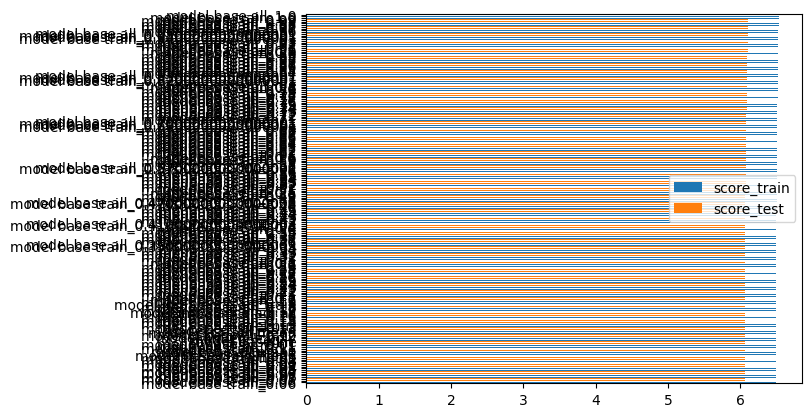

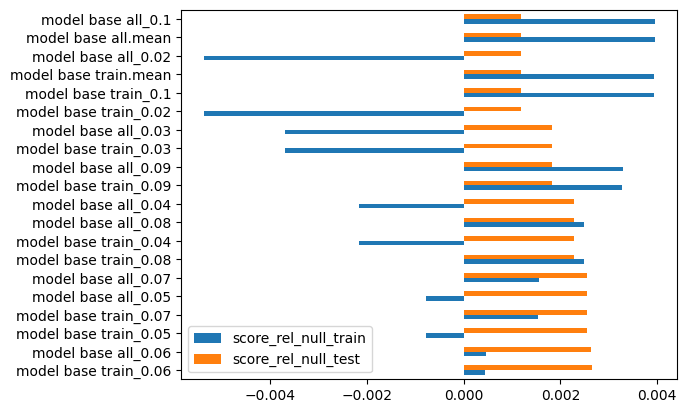

In [9]:
name, score_train, score_test = zip(*score)
df_score = pd.DataFrame({
    'score_train':score_train,
    'score_test':score_test}, index = name
)
df_score['score_rel_null_train'] = (-df_score['score_train']+df_score.loc['model baseline', 'score_train'])/df_score.loc['model baseline', 'score_train']*100
df_score['score_rel_null_test'] = (-df_score['score_test']+df_score.loc['model baseline', 'score_test'])/df_score.loc['model baseline', 'score_test']*100

df_score.sort_values(by='score_test',inplace=True)
df_score[['score_train', 'score_test']].iloc[:].plot.barh()
df_score[['score_rel_null_train', 'score_rel_null_test']].iloc[:20].plot.barh()
df_score.head(50)